In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# upload data raw
ATT_raw = pd.read_csv('/content/drive/MyDrive/Resultados_ATT/02593601Y.csv')
ATT_raw = ATT_raw.rename(columns={'Frame_ATT': 'Frame'})
Blink_raw = pd.read_csv('/content/drive/MyDrive/Resultados_Blink/02593601Y.csv')

In [ ]:
# create dataset to train
df = Blink_raw.combine_first(ATT_raw)
df = df[['Frame', 'Eye_blink_strength', 'ATT']]

In [ ]:
df.shape

(85280, 3)

In [ ]:
# calculate percentiles of ATT values in order to classify them as Low, med and high attention
ATT_25 = np.percentile(df['ATT'], 25)
ATT_50 = np.percentile(df['ATT'], 50)
ATT_75 = np.percentile(df['ATT'], 75)
ATT_max = np.max(df['ATT'])

print(f'ATT 25%: {ATT_25}')
print(f'ATT 50%: {ATT_50}')
print(f'ATT 75%: {ATT_75}')
print(f'ATT MAX: {ATT_max}')

# Blink_25 = np.percentile(df['Eye_blink_strength'], 25)
# Blink_50 = np.percentile(df['Eye_blink_strength'], 50)
# Blink_75 = np.percentile(df['Eye_blink_strength'], 75)

ATT 25%: 35.0
ATT 50%: 48.0
ATT 75%: 64.0
ATT MAX: 100


In [ ]:
# Functions to set target column
def f(row):
    if row['ATT'] <= ATT_25:
        val = -1
    elif row['ATT'] > ATT_25 and row['ATT'] < ATT_75:
        val = 0
    else:
        val = 1
    return val

def s(row):
    if row['ATT'] <= ATT_25:
        val = 'Baja'
    elif row['ATT'] > ATT_25 and row['ATT'] < ATT_75:
        val = 'Media'
    else:
        val = 'Alta'
    return val

In [ ]:
# create two new columns: Target and Target Str
df['Target'] = df.apply(f, axis=1)
df['Target Str'] = df.apply(s, axis=1)
df.Target.unique()

array([ 0, -1,  1])

In [ ]:
baja_count=df['Target'][df['Target']==-1].count()
media_count=df['Target'][df['Target']==0].count()
alta_count =df['Target'][df['Target']==1].count()

print(f'frames baja atención: {baja_count}')
print(f'frames media atención: {media_count}')
print(f'frames alta atención:{alta_count}')

frames baja atención: 23136
frames media atención: 40650
frames alta atención:21494


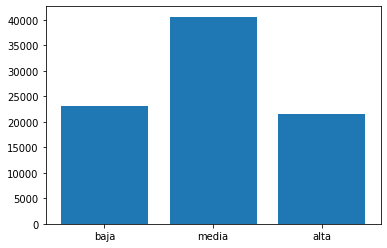

In [ ]:
df_sampled = df.sample(n=1000)

target = [baja_count, media_count, alta_count]
target_str = ['baja', 'media', 'alta']

plt.bar(target_str, target)
 
# Show Plot
plt.show()

In [ ]:
df['Eye_blink_strength'].isnull().values.any()

True

In [ ]:
df = df.dropna()

In [ ]:
df['Eye_blink_strength'].isnull().values.any()

False

In [ ]:
# Split dataset in 80% train and 20% test
X = df[['Eye_blink_strength','ATT']].values
y = df['Target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)
print(X_train.shape); 
print(X_test.shape)

(66483, 2)
(16621, 2)


In [ ]:
# build neural network by using Multi-layer Perceptron classifier (scikitLearn)
# learn more about MLP model: https://scikit-learn.org/stable/modules/neural_networks_supervised.html
mlp = MLPClassifier(hidden_layer_sizes=(3,3,3), # 3 hidden layers 
                    activation='relu', 
                    solver='adam', 
                    max_iter=100, 
                    learning_rate_init=0.001, 
                    verbose=True,
                    alpha=0.01) #adjust alpha in order to avoid overfitting (0.0001 by default)
mlp.fit(X_train,y_train) # Train model


Iteration 1, loss = 1.06638367
Iteration 2, loss = 0.82301259
Iteration 3, loss = 0.70133447
Iteration 4, loss = 0.55957712
Iteration 5, loss = 0.50215475
Iteration 6, loss = 0.46687652
Iteration 7, loss = 0.43931988
Iteration 8, loss = 0.41697327
Iteration 9, loss = 0.39730275
Iteration 10, loss = 0.37913776
Iteration 11, loss = 0.36247492
Iteration 12, loss = 0.34770703
Iteration 13, loss = 0.33380373
Iteration 14, loss = 0.31569825
Iteration 15, loss = 0.29619404
Iteration 16, loss = 0.27694484
Iteration 17, loss = 0.25572121
Iteration 18, loss = 0.23384491
Iteration 19, loss = 0.21432780
Iteration 20, loss = 0.19747040
Iteration 21, loss = 0.18442832
Iteration 22, loss = 0.17294535
Iteration 23, loss = 0.16417923
Iteration 24, loss = 0.15580941
Iteration 25, loss = 0.14816081
Iteration 26, loss = 0.13952581
Iteration 27, loss = 0.13192145
Iteration 28, loss = 0.12500642
Iteration 29, loss = 0.11818808
Iteration 30, loss = 0.11269089
Iteration 31, loss = 0.10755661
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(alpha=0.01, hidden_layer_sizes=(3, 3, 3), max_iter=100,
              verbose=True)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


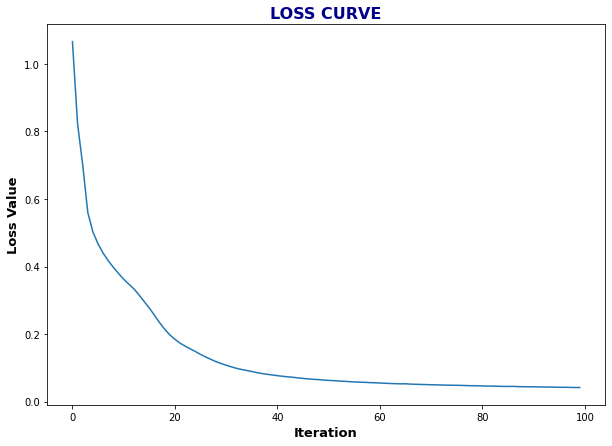

In [ ]:
# plot loss curve of training process
font_dict_title = {'family':'arial',
              'size':16,
              'weight':'bold',
              'color':'darkblue'
            }

font_dict_axis = {'family':'arial',
              'size':13,
              'weight':'bold',
            }

def plot_loss(model, font_title, font_axis, size):
  plt.figure(figsize=size)
  plt.plot(model.loss_curve_)
  plt.title('LOSS CURVE', fontdict=font_title)
  plt.xlabel('Iteration', fontdict=font_axis)
  plt.ylabel('Loss Value', fontdict=font_axis)
  return plt.show()

plot_loss(mlp, 
          font_title=font_dict_title, 
          font_axis=font_dict_axis, 
          size=(10,7))  

In [ ]:
# Validate model
predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

In [ ]:
# See classification report for train: precision, recall, f1-score, suppor, accuracy, etc.
print(classification_report(y_train,predict_train))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     18539
           0       0.99      1.00      0.99     31956
           1       0.99      0.98      0.99     15988

    accuracy                           0.99     66483
   macro avg       0.99      0.99      0.99     66483
weighted avg       0.99      0.99      0.99     66483



In [ ]:
# See classification report for test: precision, recall, f1-score, suppor, accuracy, etc.
print(classification_report(y_test,predict_test))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      4597
           0       0.99      1.00      0.99      7996
           1       0.99      0.98      0.99      4028

    accuracy                           0.99     16621
   macro avg       0.99      0.99      0.99     16621
weighted avg       0.99      0.99      0.99     16621



In [ ]:
# adjust the hyperparameters of MLP classifier to get more perfect performance (avoid overfitting)
mlp_hyper = MLPClassifier(max_iter=10)
parameter_space = {
    'hidden_layer_sizes': [(3,3,3), (8,8,8), (10,10,10)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.01, 0.05],
    'learning_rate': ['constant','adaptive'],
}


In [ ]:
# GridSearch method (cross validation)
clf = GridSearchCV(mlp_hyper, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=10), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'], 'alpha': [0.01, 0.05],
                         'hidden_layer_sizes': [(3, 3, 3), (8, 8, 8),
                                                (10, 10, 10)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [ ]:
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (10, 10, 10), 'learning_rate': 'constant', 'solver': 'adam'}


In [ ]:
# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.625 (+/-0.204) for {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (3, 3, 3), 'learning_rate': 'constant', 'solver': 'sgd'}
0.925 (+/-0.109) for {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (3, 3, 3), 'learning_rate': 'constant', 'solver': 'adam'}
0.668 (+/-0.289) for {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (3, 3, 3), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.840 (+/-0.012) for {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (3, 3, 3), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.838 (+/-0.003) for {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (8, 8, 8), 'learning_rate': 'constant', 'solver': 'sgd'}
0.971 (+/-0.031) for {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (8, 8, 8), 'learning_rate': 'constant', 'solver': 'adam'}
0.833 (+/-0.001) for {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (8, 8, 8), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.978 (+/-0.021) for {'activati

In [ ]:
mlp_2 = MLPClassifier(hidden_layer_sizes=(10,10,10), # 3 hidden layers 
                    activation='tanh', 
                    solver='adam', 
                    max_iter=100, 
                    learning_rate='constant', 
                    verbose=True,
                    alpha=0.01) #adjust alpha in order to avoid overfitting (0.0001 by default)
mlp_2.fit(X_train,y_train) # Train model

Iteration 1, loss = 0.58181890
Iteration 2, loss = 0.34887371
Iteration 3, loss = 0.21886812
Iteration 4, loss = 0.12147632
Iteration 5, loss = 0.08708457
Iteration 6, loss = 0.07246217
Iteration 7, loss = 0.05946655
Iteration 8, loss = 0.06232345
Iteration 9, loss = 0.04639437
Iteration 10, loss = 0.04104684
Iteration 11, loss = 0.04719064
Iteration 12, loss = 0.04164618
Iteration 13, loss = 0.04069438
Iteration 14, loss = 0.03857876
Iteration 15, loss = 0.03518495
Iteration 16, loss = 0.03073841
Iteration 17, loss = 0.03601794
Iteration 18, loss = 0.03172768
Iteration 19, loss = 0.02856873
Iteration 20, loss = 0.03508640
Iteration 21, loss = 0.03233227
Iteration 22, loss = 0.02641674
Iteration 23, loss = 0.02725090
Iteration 24, loss = 0.03588957
Iteration 25, loss = 0.02583111
Iteration 26, loss = 0.02445952
Iteration 27, loss = 0.02811929
Iteration 28, loss = 0.03259142
Iteration 29, loss = 0.02863776
Iteration 30, loss = 0.02831568
Iteration 31, loss = 0.02976099
Iteration 32, los

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(10, 10, 10),
              max_iter=100, verbose=True)

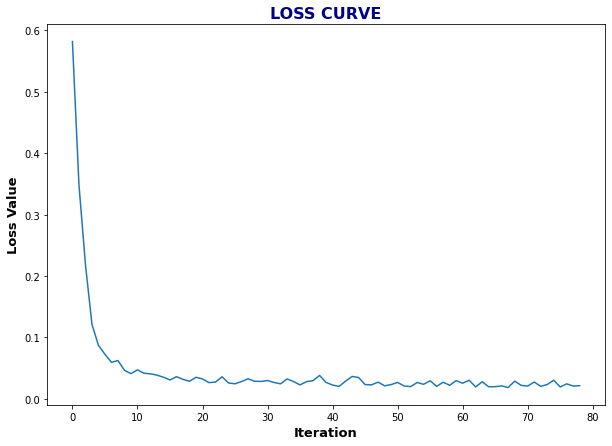

In [ ]:
plot_loss(mlp_2, 
          font_title=font_dict_title, 
          font_axis=font_dict_axis, 
          size=(10,7)) 

In [ ]:
# Validate model
predict_train_2 = mlp_2.predict(X_train)
predict_test_2 = mlp_2.predict(X_test)

# See classification report for train: precision, recall, f1-score, suppor, accuracy, etc.
print(classification_report(y_train,predict_train_2))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     18539
           0       1.00      0.94      0.97     31956
           1       0.90      1.00      0.95     15988

    accuracy                           0.97     66483
   macro avg       0.97      0.98      0.97     66483
weighted avg       0.98      0.97      0.97     66483



In [ ]:
print(classification_report(y_test,predict_test_2))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      4597
           0       1.00      0.94      0.97      7996
           1       0.90      1.00      0.95      4028

    accuracy                           0.97     16621
   macro avg       0.97      0.98      0.97     16621
weighted avg       0.98      0.97      0.97     16621



In [ ]:
pickle.dump(mlp_2, open("/content/drive/MyDrive/model_mlp.pkl", "wb"))